In [1]:
# -*- coding: utf-8 -*-

# 引入模块
from sklearn.linear_model import LinearRegression
import pandas as pd  # 数据分析
import numpy as np  # 科学计算
from sklearn import linear_model
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
scaler = preprocessing.StandardScaler()

In [3]:
# 读取数据-hgt
train_hgt = pd.read_csv("data\\train.csv")
test_hgt = pd.read_csv("data\\test.csv")
submit_hgt = pd.read_csv("data\\sample_submit.csv")

In [4]:
# 相关系数，查看表-2018年12月30日  16:03
corr = train_hgt.corr()
# cov=train_hgt.cov()
# corr[np.abs(corr)<0.2] = " "
corr 

,id,city,hour,is_workday,weather,temp_1,temp_2,wind,y
id,1.000000,0.014365,0.016581,0.005416,0.000596,-0.005328,-0.005753,-0.007526,-0.000126
city,0.014365,1.000000,0.004966,0.001449,0.018304,-0.057240,-0.054218,0.010495,-0.165946
hour,0.016581,0.004966,1.000000,0.016963,-0.028193,0.134849,0.132114,0.132240,0.406489
is_workday,0.005416,0.001449,0.016963,1.000000,0.040110,0.054786,0.053948,0.001880,0.029477
weather,0.000596,0.018304,-0.028193,0.040110,1.000000,-0.107515,-0.110732,0.025941,-0.151416
temp_1,-0.005328,-0.057240,0.134849,0.054786,-0.107515,1.000000,0.987357,-0.007017,0.417115
temp_2,-0.005753,-0.054218,0.132114,0.053948,-0.110732,0.987357,1.000000,-0.042559,0.413942
wind,-0.007526,0.010495,0.132240,0.001880,0.025941,-0.007017,-0.042559,1.000000,0.107231
y,-0.000126,-0.165946,0.406489,0.029477,-0.151416,0.417115,0.413942,0.107231,1.000000


In [5]:
# 查看基本信息-hgt-2018年12月30日 21:31
# train_hgt.dtypes  
# train_hgt.count() # 查看有没有缺省的字段
# type(train_hgt.weather)
# data_train.groupby("temp_2").sum().plot(y='y',marker='o')
# data_train.groupby("temp_2").sum().plot(y='y',marker='o')
# data_train.median() # 所有值的中位数
# train_hgt.empty
# """
# #1、城市影响：城市0的借取量高于城市1，借取量的高峰在早上8点和晚上5/6点，和日常上下班高峰时间基本吻合，估计都是命苦的上班族
# #2、工作日与休息日影响：可以看出，只对城市0有影响，但影响有限
# #3、温度影响：温度对借取量呈现线性相关
# #4、体感温度影响：体感温度对借取量呈现线性相关
# #5、天气影响：天气对借取量影响明显，而且城市0的人好猛，强降雨天气依然借取出行
# #6、风速影响：风速对借取量也有影响，无风或大风天借取量较少
# """


In [9]:
# 删除id  -hgt
train_hgt.drop('id',axis=1,inplace=True)
test_hgt.drop('id',axis=1,inplace=True)

#删除 is_workday 字段，对预测结果影响比较小-hgt
train_hgt.drop('is_workday',axis=1,inplace=True)
test_hgt.drop('is_workday',axis=1,inplace=True)

# 取出训练集的y
y_train_hgt = train_hgt.pop('y')
# y_train_hgt.head() 


In [120]:
# 处理原始train数据-hgt（读热形式one-hot形式）
data_original_city = pd.get_dummies(train_hgt["city"],prefix="city")
data_original_hour = pd.get_dummies(train_hgt["hour"],prefix="hour")
data_original_weather = pd.get_dummies(train_hgt["weather"],prefix="weather")
data_original_wind = pd.get_dummies(train_hgt["wind"],prefix="wind")
data_original_deal = pd.concat([data_original_city,data_original_hour,data_original_weather,data_original_wind],axis=1)
data_original_deal["temp_1"]=train_hgt["temp_1"]
xdataTrain,data_test,ydataTrain, ydataVolidate=train_test_split(data_original_deal,y_train_hgt,test_size=0.3, random_state=0)  # ？意义

In [122]:
data_original_deal.head()

,city_0,city_1,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,weather_4,wind_0,wind_1,wind_2,wind_3,wind_4,wind_5,wind_6,wind_7,temp_1
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3.0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,21.0
2,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,25.3
3,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,15.7
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,21.1


   temp_2  temp_1
0     0.7     3.0
1    24.9    21.0
2    27.4    25.3
3    16.2    15.7
4    25.0    21.1


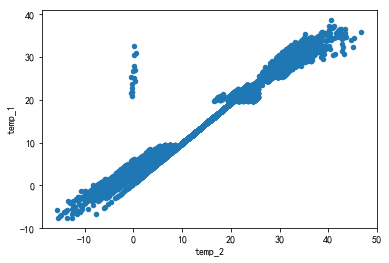

      city  hour  weather  temp_1  temp_2  wind
1066     0    23        3    21.7    -0.4     2
2547     0     4        1    21.9    -0.2     1
3923     0     9        1    25.1     0.2     0
3944     0    19        2    27.1     0.3     3
4026     0     0        1    23.7    -0.3     1
4240     0     8        1    24.4     0.4     1
4276     0     6        1    20.9    -0.2     1
4639     0    18        2    31.0     0.5     2
5031     0    14        1    32.5     0.1     3
5089     0     2        1    22.7    -0.3     1
5251     0     3        1    21.9    -0.2     0
5743     0    10        1    26.7    -0.1     1
6099     0    11        1    27.9     0.2     2
6249     0    20        2    25.3    -0.5     2
9506     0    12        1    30.6     0.1     2
   temp_2  temp_1
0     0.7     3.0
1    24.9    21.0
2    27.4    25.3
3    16.2    15.7
4    25.0    21.1


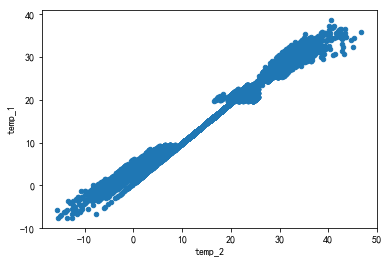

In [10]:
# 特征工程处理数据-2018年12月23日
# train_hgt.head()
# print (train_hgt.info())
# print(train_hgt.describe())

data = pd.concat([train_hgt['temp_2'],train_hgt['temp_1']], axis=1)
# data = pd.DataFrame(train_hgt)
data.plot.scatter(x='temp_2', y='temp_1')
print(data.head())
plt.show()

# # 产生1000个4列正态分布的随机数
# data = pd.DataFrame(np.random.randn(1000, 4), columns=list("ABCD"))
# # 打印出前几行的数据，方便我们调试其中的数据值
# print(data.head())
# # 显示散点图
# data.plot.scatter(x='B', y='B')
# # 显示图
# plt.show()
# 过滤数据
print(train_hgt[(train_hgt["temp_1"]>18) & (train_hgt["temp_2"]<5)])
# 删除行   删除列
train_hgt=train_hgt.drop([1066,2547,3923,3944,4026,4240,4276,4639,5031,5089,5251,4732,6099,6249,9506])
train_hgt=train_hgt.drop([5743])

# 第二次打印图像
data = pd.concat([train_hgt['temp_2'],train_hgt['temp_1']], axis=1)
# data = pd.DataFrame(train_hgt)
data.plot.scatter(x='temp_2', y='temp_1')
print(data.head())
plt.show()



In [11]:
#处理对应的y值 y_train_hgt
y_train_hgt=y_train_hgt.drop([1066,2547,3923,3944,4026,4240,4276,4639,5031,5089,5251,4732,6099,6249,9506,5743])

In [14]:
# y_train_hgt.shape
# len(y_train_hgt)
train_hgt.head()
# y_train_hgt.shape
# train_hgt.shape

,city,hour,weather,temp_1,temp_2,wind
0,0,22,2,3.0,0.7,0
1,0,10,1,21.0,24.9,3
2,0,0,1,25.3,27.4,0
3,0,7,1,15.7,16.2,0
4,1,10,1,21.1,25.0,2


In [30]:
# 删除异常值后，处理train_hgt 数据(读热编码形式，即one-hot形式）-hgt
data_pre_city = pd.get_dummies(train_hgt["city"],prefix="city")
data_pre_hour = pd.get_dummies(train_hgt["hour"],prefix="hour")
data_pre_weather = pd.get_dummies(train_hgt["weather"],prefix="weather")
data_pre_wind = pd.get_dummies(train_hgt["wind"],prefix="wind")
data_pre_deal = pd.concat([data_pre_city,data_pre_hour,data_pre_weather,data_pre_wind],axis=1)
data_pre_deal["temp_1"]=train_hgt["temp_1"]
xdataTrain,data_test,ydataTrain, ydataVolidate=train_test_split(data_pre_deal,y_train_hgt,test_size=0.3, random_state=0)  # ？意义

In [15]:
# 对删除异常值后的train_hgt进行数据数据 （非one-hot形式）
train_hgt.drop('temp_2',axis=1,inplace=True)


In [33]:
train_hgt.head()
# y_train_hgt.shape
# train_hgt.shape

,city,hour,weather,temp_1,wind
0,0,22,2,3.0,0
1,0,10,1,21.0,3
2,0,0,1,25.3,0
3,0,7,1,15.7,0
4,1,10,1,21.1,2


In [34]:
# 对数据进行标准化
sc = StandardScaler()
sc.fit(train_hgt) # 估算每个特征的平均值和标准差
# sc.mean_ # 查看特征的平均值，结果是array([ 0.5005008 , 11.52804487,  1.42748397, 15.25333534,  1.24819712])
# sc.scale_ # 查看特征的标准差，结果是arrayarray([0.49999975, 6.90928331, 0.63749516, 9.02585734, 1.09600123])
train_hgt_std = sc.transform(train_hgt)
# 注意：这里我们要用同样的参数来标准化测试集，使得测试集和训练集之间有可比性
# test_hgt_std = sc.transform(test_hgt)
print train_hgt_std

#第一种方式：把数据写入
# 存储到csv格式下
# name=['y']
# testresult=pd.DataFrame(columns=name,data=y_pred_hgt)
# print(testresult)
# testresult.to_csv('E:/contest-hgt/sample_submit5.csv',encoding='gbk')

[[-1.0010021   1.51563551  0.89807117 -1.35758132 -1.1388647 ]
 [-1.0010021  -0.22115823 -0.67056819  0.63668906  1.5983585 ]
 [-1.0010021  -1.66848635 -0.67056819  1.1130981  -1.1388647 ]
 ...
 [ 0.9989989  -1.66848635 -0.67056819 -0.62634885 -1.1388647 ]
 [-1.0010021   0.93670426  0.89807117  1.34576298 -0.22645697]
 [-1.0010021  -0.36589104  0.89807117 -1.33542276  0.68595076]]


In [35]:
# 随机切分 样本集为训练集和测试集 train_hgt_std
xdataTrain,data_test,ydataTrain, ydataVolidate=train_test_split(train_hgt_std,y_train_hgt,test_size=0.3, random_state=0)  # ？意义

In [37]:
# 打印切分后的数据信息，非one-hot形式

# xdataTrain.shape
# xdataTrain.head()
# train_hgt.shape  #对应的x值（非one-hot形式）
# y_train_hgt.shape  #对应的x值（非one-hot形式）
# data_test.head()
# data_test.shape
# ydataTrain.head()
# ydataVolidate.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [38]:
# 参考别人参数调优后的xgboost回归模型 ('RMSE TEST: ', 24.359587100225273)
model_xgboost= XGBRegressor( learning_rate =0.1, n_estimators=200,max_depth=5,
                            min_child_weight=5,gamma=0.0,colsample_bytree= 0.9, subsample=0.7,reg_alpha=0.001)

# 自己参数调优后的xgboost回归模型
# model_xgboost= XGBRegressor( learning_rate =0.1, n_estimators=100,
#                                 max_depth=5,min_child_weight=5,gamma=0.0,
#                                 colsample_bytree= 0.7, subsample=0.6,
#                                 reg_alpha=0)
model_xgboost.fit(xdataTrain, ydataTrain)
y_pred = model_xgboost.predict(data_test)

#自己调优参数过程-2018年12月23日
# 第1步：调参n_estimators
# param_test1 = {
#     'n_estimators':range(100,1000,100)
# }
# gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1,  max_depth=5,
#                                         min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#                                          nthread=4, scale_pos_weight=1, seed=27),
#                        param_grid = param_test1, iid=False, cv=5)


# #第2步：调参max_depth，min_child_weight
# param_test2 = {
#         'max_depth':range(3,10,2),
#     'min_child_weight':range(1,6,2)
# }
# gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=100 ),
#                        param_grid = param_test2)
# # gsearch1.fit(xdataTrain, ydataTrain)
# # print(gsearch1.best_params_, gsearch1.best_score_)
# gsearch2.fit(xdataTrain, ydataTrain)
# print(gsearch2.best_params_, gsearch2.best_score_)

#第3步：调参 max_depth，min_child_weight 根据上次结构上下浮动456，进行重写组合评估

# #第4步：调参 gamma
# param_test4 = {
#     'gamma': [i / 10.0 for i in range(0, 5)]
# }
# gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=100,max_depth=5,min_child_weight=5 ),
#                        param_grid = param_test4)
# gsearch4.fit(xdataTrain, ydataTrain)
# print(gsearch4.best_params_, gsearch4.best_score_)

# #第5步：调参 subsample ，colsample_bytree  ({'subsample': 0.7, 'colsample_bytree': 0.6}
# param_test5 = {
#     'subsample': [i / 10.0 for i in range(6, 10)],
#     'colsample_bytree': [i / 10.0 for i in range(6, 10)]
# }
# g1search5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=100,max_depth=5,min_child_weight=5,gamma=0.0 ),
#                        param_grid = param_test5)
# gsearch5.fit(xdataTrain, ydataTrain)
# print(gsearch5.best_params_, gsearch5.best_score_)

# #第6步：调参 reg_alpha 
# param_test6 = {
#     'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
# }
# gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=100,max_depth=5,min_child_weight=5,
#                                                  gamma=0.0,colsample_bytree= 0.7, subsample=0.6),param_grid = param_test6)
# gsearch6.fit(xdataTrain, ydataTrain)
# print(gsearch6.best_params_, gsearch6.best_score_)

# 若预测值是负数，则取0
y_pred = map(lambda x: x if x >= 0 else 0, y_pred)

# 根方误差 对模型效果进行评估-hgt
n=len(ydataVolidate)
# round(np.sqrt(np.mean((y_pred - ydataVolidate) ** 2)),2)   根方误差公式（正确与否待验证） 
# print (np.array(y_pred).flatten())
# print(np.array(ydataVolidate).flatten())
# print(np.array(y_pred).flatten() - np.array(ydataVolidate).flatten())  
rmse_test = np.sqrt(np.sum((np.array(y_pred).flatten() - np.array(ydataVolidate).flatten())**2)/n) 
rmse_test1= round(np.sqrt(np.mean((y_pred - ydataVolidate) ** 2)),2)   # 根方误差公式（正确与否待验证） 
print("RMSE TEST: ", rmse_test)     
print("RMSE TEST: ", rmse_test1)  

('RMSE TEST: ', 24.127542427069173)
('RMSE TEST: ', 24.13)


In [99]:
# 打印测试数据基本信息 --对7000测试数据进行预测（使用非one-hot形式）
test_hgt.drop('temp_2',axis=1,inplace=True)
test_hgt.head()

,city,hour,is_workday,weather,temp_1,wind
0,0,1,1,1,20.7,0
1,1,18,0,1,32.4,1
2,1,16,1,1,27.6,4
3,1,11,0,1,9.3,0
4,0,10,1,2,24.8,2


In [100]:
# 模型预测 model_xgboost
y_pred_hgt = model_xgboost.predict(test_hgt)  # xgboost模型   ('RMSE TEST: ', 16.136608572140624) ('RMSE TEST: ', 24.65)
# y_pred_hgt = mode_rf.predict(data_originaltest_deal) # 随机森林('RMSE TEST: ', 17.11156482206927) ('RMSE TEST: ', 26.13)
# y_pred_hgt = mode_reg.predict(data_originaltest_deal) # reg ('RMSE TEST: ', 17.75160517937381) ('RMSE TEST: ', 27.12)

y_pred_hgt = map(lambda x: x if x >= 0 else 0, y_pred_hgt)
# len(y_pred_hgt)

#测试结果
ncount=len(test_hgt)
rmse_test = np.sqrt(np.sum((np.array(y_pred).flatten() - np.array(ydataVolidate).flatten())**2)/ncount)
rmse_test1= round(np.sqrt(np.mean((y_pred - ydataVolidate) ** 2)),2)   # 根方误差公式（正确与否待验证） 
print("RMSE TEST: ", rmse_test)     
print("RMSE TEST: ", rmse_test1)  
# 存储到csv格式下
name=['y']
testresult=pd.DataFrame(columns=name,data=y_pred_hgt)
print(testresult)
testresult.to_csv('E:/contest-hgt/sample_submit5.csv',encoding='gbk')

# 存储方法二
# submit['y'] = testresult
# submit.to_csv('E:/contest-hgt/sample_submit3.csv',index=False)


('RMSE TEST: ', 9.664375134198867)
('RMSE TEST: ', 14.77)
               y
0       6.880145
1      86.211868
2      83.542747
3      58.461414
4      51.201424
5      17.540800
6      78.438805
7      55.495476
8       1.028931
9      44.257435
10     31.788500
11    170.642365
12     62.524353
13      0.569576
14     55.863613
15    121.407471
16     98.278648
17     20.567692
18    110.391846
19     98.571716
20      1.711056
21     68.457039
22     31.695168
23     70.614586
24     87.080444
25    137.438873
26     29.434139
27     56.941704
28     98.407539
29     71.077484
...          ...
6970   20.550489
6971   74.928635
6972   36.173019
6973    8.201201
6974   55.213459
6975   14.422267
6976   10.587351
6977   61.693016
6978   10.683946
6979   99.024773
6980   69.092278
6981    9.807493
6982   25.158369
6983    2.042257
6984   46.534988
6985    1.368975
6986   36.077335
6987   56.311817
6988   45.079052
6989   72.314957
6990   59.315262
6991   14.151293
6992   54.399403
6993   

In [111]:
# 尝试随机森林模型效果 ('RMSE TEST: ', 26.228917419834413)  
# mode_rf = RandomForestRegressor(n_estimators=100)
# 尝试随机森林模型效果 ('RMSE TEST: ', 26.117623195697856)
mode_rf = RandomForestRegressor(n_estimators=1000)
mode_rf.fit(xdataTrain,ydataTrain)
y_pred = mode_rf.predict(data_test)

# 若预测值是负数，则取0
y_pred = map(lambda x: x if x >= 0 else 0, y_pred)

# 根方误差 对模型效果进行评估-hgt
n=len(ydataVolidate)
rmse_test = np.sqrt(np.sum((np.array(y_pred).flatten() - np.array(ydataVolidate).flatten())**2)/n)
print("RMSE TEST: ", rmse_test)     # 13.770731326

('RMSE TEST: ', 26.128529652232928)


In [114]:
# 线性回归模型训练
mode_reg=LinearRegression()
mode_reg.fit(xdataTrain,ydataTrain)
y_pred = mode_reg.predict(data_test)

# 若预测值是负数，则取0
y_pred = map(lambda x: x if x >= 0 else 0, y_pred)

# 根方误差 对模型效果进行评估-hgt
n=len(ydataVolidate)
rmse_test = np.sqrt(np.sum((np.array(y_pred).flatten() - np.array(ydataVolidate).flatten())**2)/n)
print("RMSE TEST: ", rmse_test)     # 13.770731326

('RMSE TEST: ', 27.116024813816875)


In [117]:
# 测试数据处理
data_originaltest_city = pd.get_dummies(test_hgt["city"],prefix="city")
data_originaltest_hour = pd.get_dummies(test_hgt["hour"],prefix="hour")
data_originaltest_weather = pd.get_dummies(test_hgt["weather"],prefix="weather")
data_originaltest_wind = pd.get_dummies(test_hgt["wind"],prefix="wind")
data_originaltest_deal = pd.concat([data_originaltest_city,data_originaltest_hour,data_originaltest_weather,data_originaltest_wind],axis=1)
data_originaltest_deal["temp_1"]=test_hgt["temp_1"]

# 模型预测 model_xgboost
y_pred_hgt = model_xgboost.predict(data_originaltest_deal)  # xgboost模型   ('RMSE TEST: ', 16.136608572140624) ('RMSE TEST: ', 24.65)
# y_pred_hgt = mode_rf.predict(data_originaltest_deal) # 随机森林('RMSE TEST: ', 17.11156482206927) ('RMSE TEST: ', 26.13)
# y_pred_hgt = mode_reg.predict(data_originaltest_deal) # reg ('RMSE TEST: ', 17.75160517937381) ('RMSE TEST: ', 27.12)

y_pred_hgt = map(lambda x: x if x >= 0 else 0, y_pred_hgt)
# len(y_pred_hgt)

#测试结果
ncount=len(test_hgt)
rmse_test = np.sqrt(np.sum((np.array(y_pred).flatten() - np.array(ydataVolidate).flatten())**2)/ncount)
rmse_test1= round(np.sqrt(np.mean((y_pred - ydataVolidate) ** 2)),2)   # 根方误差公式（正确与否待验证） 
print("RMSE TEST: ", rmse_test)     
print("RMSE TEST: ", rmse_test1)  
# 存储到csv格式下
# name=['y']
# testresult=pd.DataFrame(columns=name,data=y_pred_hgt)
# print(testresult)
# testresult.to_csv('E:/contest-hgt/sample_submit2.csv',encoding='gbk')

# 存储方法二
# submit['y'] = testresult
# submit.to_csv('E:/contest-hgt/sample_submit.csv',index=False)


('RMSE TEST: ', 16.136608572140624)
('RMSE TEST: ', 24.65)
